## [Description](#Description_)
## [Research](#Research_)
## [Setup](#Setup_)
## [0. Разминка](#0._Разминка_)
## [1. Данные](#1._Данные_)
## [2. Простая аналитика](#2._Простая_аналитика_)
## [3. Качество](#3._Качество_)
## [4. Сведение к задаче регрессии](#4._Сведение_к_задаче_регрессии_)
## [5. ARIMA-подобные модели](#5._ARIMA-подобные_модели_)
## [6. Итоговое сравнение](#6._Итоговое_сравнение_)

# Лабораторная работа 5. Временные ряды. <span id=Description_></span>


Результат лабораторной работы &mdash; отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам &mdash; меньше проверять, вам &mdash; проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу &mdash; 10 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Research <span id=Research_></span>

https://mse.msu.ru/wp-content/uploads/2021/03/Введение-в-анализ-временных-рядов-1.pdf

## Setup <span id=Setup_></span>

### Markdown

In [3]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

### Imports

In [5]:
import catboost
import functools
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima
import pmdarima.pipeline
import scipy
import seaborn
import sklearn.neural_network
import statsmodels
import tbats
import tsfresh
import tqdm.autonotebook
import types
from typing import Callable, Any
import zipfile

/var/folders/5w/gytwm8sd6vldh9ym3dvj_x_m0000gn/T/ipykernel_27927/3368128557.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


In [5]:
seaborn.set(palette="Set2")
pd.plotting.register_matplotlib_converters()

<IPython.core.display.Javascript object>

## 0. Разминка<span id=0._Разминка_></span>

#### Задача 1. [2 балла]

Даны временные ряды
* $y_t = 2 + y_{t-1} - 0.5 y_{t-2} + 0.5 y_{t-3} + \varepsilon_t - 2\varepsilon_{t-1} + \varepsilon_{t-2}$,
* $y_t = -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}$,

где $\varepsilon_t$ &mdash; гауссовский белый шум со средним 0 и дисперсией $\sigma^2$, который так же не зависит от $y_{t-i}, i \geqslant 1$. 

**1.** Являются ли ряды стационарными? 

**2.** Определите тип процесса в терминах ARIMA($p, d, q$).

**3.** Если временной ряд стационарен, вычислите математическое ожидание и дисперсию $y_t$.

---
Определим лаговый оператор:

$\operatorname{L}y_t := y_{t−1}$

Ряд называется стационарным, если:

1. $\operatorname{E}y_t \equiv const$
2. $\operatorname{cov}(y_t, y_{t+h}) = \gamma(h)$

Второе свойство можно записать как $\operatorname{cov}(L^h y_t, y_t) = \gamma(h)$. Простейший пример стационарного ряда - это белый шум $\epsilon_t$, для которого:

1. $\operatorname{E}y_t = 0$ 
2. $\operatorname{cov}(y_t, y_{t+h}) = \sigma^2\mathbb{1}[h == 0]$

Модель $y_t \sim \text{ARMA}(p,q)$ определяется как:

$\displaystyle{
y_t = 
\mu + \sum_{i=1}^{p}\phi_i y_{t-i} + \epsilon_t + \sum_{i=1}^{q}\theta_i\epsilon_{t-i} =
\mu + \sum_{i=1}^{p}\phi_i L^i y_{t} + \epsilon_t + \sum_{i=1}^{q}\theta_iL^i\epsilon_{t},
}$

где $\epsilon_t$ есть белый шум. Перепишем это в более однородном виде:

$\displaystyle{
y_t  - \sum_{i=1}^{p}\phi_i L^i y_{t} = \mu + \epsilon_t + \sum_{i=1}^{q}\theta_i L^i\epsilon_{t}\\
\phi(L)y_t = \mu + \theta(L)\epsilon_{t}
}$

где

$\displaystyle{
\phi(x) =  1 - \sum_{i=1}^{p}\phi_i x^i\\
\theta(x) =  1 + \sum_{i=1}^{q}\theta_i x^i
}$

Для модели $\text{ARMA}$ справедливо утверждение, что она определяет стационарный ряд $\Leftrightarrow$ все корни многочлена $\phi(x)$ больше 1 по модулю. Воспользуемся этим для решения пункта 1:

**1.** 

$\displaystyle{
y_t = 2 + y_{t-1} - 0.5 y_{t-2} + 0.5 y_{t-3} + \varepsilon_t - 2\varepsilon_{t-1} + \varepsilon_{t-2}\\
\phi(x) = 1 - x + 0.5x^2 - 0.5x^3 = (1 - x)(1 - 0.5x^2) = (1-x)(1 - \sqrt{0.5}x)(1 + \sqrt{0.5}x)
}$

Поскольку $\phi(x)$ имеет корень 1, то ряд $y_t$ не стационарен.

$\displaystyle{
y_t = -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3} \\
\phi(x) = 1 + x^2 + 0.25 x^4 = (1 + 0.5x^2)^2 = (1 + i\sqrt{0.5}x)^2 (1 - i\sqrt{0.5}x)^2
}$

Корни $\phi(x)$ - это $\pm i\sqrt{2}$, они по модулю равны $\sqrt{2} > 1$, значит ряд стационарен.

**2.**

Операция дифференцирования ряда обозначается как 

$\displaystyle{
\Delta y_t = y_t - y_{t-1} = y_t - \operatorname{L} y_t = (1 - \operatorname{L}) y_t
}$

Модель $y_t \sim \text{ARIMA}(p,k,q)$ определяется как:

1. k - минимальный порядок дифференцирования, что $\Delta^k y_t$ есть стационарный ряд
2. $\Delta^k y_t \sim \text{ARMA}(p,q)$

Второй ряд есть $\text{ARIMA}(4,0,3)$. Чтобы понять тип первого ряда, нужно его продиффреницировать:

$\displaystyle{
\Delta y_t = 2 - 0.5 \Delta y_{t-2} + \Delta \varepsilon_t - \Delta \varepsilon_{t-1}\\
\phi(x) = 1 + 0.5x^2 = (1 + i\sqrt{0.5}x)(1 - i\sqrt{0.5}x)
}$

Корни $\phi(x)$ по модулю равны $\sqrt{2}$, значит первый ряд есть $\text{ARIMA}(2,1,1)$.

**3.**

Математическое ожидание второго ряда:

$\displaystyle{
\operatorname{E}y_t =
\operatorname{E}(-1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
-1 - \operatorname{E}y_{t} - 0.25 \operatorname{E}y_{t}\\
\operatorname{E}y_t = -\frac{1}{2.25} = -\frac{4}{9}
}$

Посчитаем дисперсию с учетом того, что для стационарной $\text{ARMA}$ справедливо следующее утверждение:

$\operatorname{cov}(y_t, \varepsilon_{t+h}) = 0, h > 0$

$\displaystyle{
\operatorname{Var}y_t = 
\operatorname{Var}(-1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
\operatorname{Var}y_{t} + \frac{1}{16} \operatorname{Var}y_{t} + \sigma^2 + \sigma^2 
+0.25\operatorname{cov}(y_{t-2}, y_{t-4}) + \operatorname{cov}(y_{t-2}, \varepsilon_{t-3})\\
 \frac{1}{16} \operatorname{Var}y_{t} + 2\sigma^2
+0.25\gamma(2) + \operatorname{cov}(y_{t}, \varepsilon_{t-1})\\
}$

Поскольку $y_{t}$ не зависит ни от $\varepsilon_{t-1}$, ни от $y_{t-1}$, то $\operatorname{cov}(y_{t}, \varepsilon_{t-1}) =0$, получаем:

$\operatorname{Var}y_t = -32 \sigma^2 -4\gamma(2)$

$\gamma(2) =
\operatorname{cov}(y_{t-2}, y_t) =
\operatorname{cov}(y_{t-2}, -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
-\operatorname{Var}y_t -0.25 \gamma(2)\\
\operatorname{Var}y_t = -1.25 \gamma(2) = -32 \sigma^2 -4\gamma(2)\\
\gamma(2) = -\frac{128}{11}\sigma^2\\
\operatorname{Var}y_t = \frac{160}{11}\sigma^2
$

Первый ряд не стационарен, но можно посчитать матожидание и дисперсию его производной:

$\displaystyle{
\operatorname{E}\Delta y_t = 
\operatorname{E}(2 - 0.5 \Delta y_{t-2} + \Delta \varepsilon_t - \Delta \varepsilon_{t-1}) =
2 -0.5\operatorname{E}\Delta y_t\\
\operatorname{E}\Delta y_t = \frac{4}{3}
}$

$\displaystyle{
\operatorname{Var}\Delta y_t = 
\operatorname{Var}(2 - 0.5 \Delta y_{t-2} + \Delta \varepsilon_t - \Delta \varepsilon_{t-1}) =
0.25\operatorname{Var}\Delta y_{t} + \sigma^2 + \sigma^2\\
\operatorname{Var}\Delta y_{t} = \frac{8}{3}\sigma^2
}$

## 1. Данные <span id=1._Данные_></span>

В качестве данных рассмотрим известный набор данных с параметрами погоды в одной точке земной поверхности, доступный нам с частотой дискретизации в 10 минут. Описание данных доступно по <a href="https://keras.io/examples/timeseries/timeseries_weather_forecasting/">ссылке</a>.

Скачаем данные

In [6]:
def wget_download_to_filepath(url: str, directory: str = "", filename: str = "") -> str:
    filename = filename or os.path.basename(url)
    filename = os.path.join(directory, filename)
    !wget -O {filename} {url}
    return filename


def unzip_all(zip_filepath: str) -> list[str]:
    zip_file = zipfile.ZipFile(zip_filepath)
    zip_file.extractall()
    return zip_file.namelist()

<IPython.core.display.Javascript object>

Немного преобразуем данные, рассмотрев максимальное значение каждой величины за сутки.

In [7]:
def simplify_columns(df) -> list[str]:
    return [c.split("(")[0].strip() for c in df.columns]


def preprocess_df(weather_df):
    weather_df["Date"] = pd.to_datetime(
        weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S"
    )
    weather_df_daily = weather_df.set_index("Date").resample("D").max().reset_index()
    del weather_df_daily["Date Time"]
    weather_df_daily = weather_df_daily.set_index("Date")
    weather_df_daily.columns = simplify_columns(weather_df_daily)
    weather_df_daily = weather_df_daily.dropna()
    return weather_df_daily

<IPython.core.display.Javascript object>

In [8]:
CONFIG = types.SimpleNamespace()
CONFIG.URL = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

DATA = types.SimpleNamespace()
DATA.df = preprocess_df(
    pd.read_csv(unzip_all(wget_download_to_filepath(CONFIG.URL))[0])
)

DATA.df.head()

--2023-04-25 14:01:03--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.21.176, 142.250.74.16, 142.250.74.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.21.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  10.2MB/s    in 1.3s    

2023-04-25 14:01:05 (10.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd
Date,,,,,,,,,,,,,,
2009-01-01,1000.87,-4.17,269.00,-5.36,94.8,4.48,4.09,0.49,2.55,4.09,1318.81,2.51,3.63,357.9
2009-01-02,1002.65,-2.12,271.12,-3.88,96.3,5.22,4.58,0.70,2.86,4.59,1298.51,3.87,6.13,358.8
2009-01-03,1002.49,-0.82,272.59,-6.09,93.9,5.75,3.87,2.86,2.41,3.86,1323.70,3.64,4.88,357.2
2009-01-04,992.93,-0.63,273.55,-2.26,93.9,5.83,5.17,1.53,3.27,5.25,1274.06,3.95,7.13,257.0
2009-01-05,997.54,-1.44,272.89,-2.45,93.2,5.49,5.10,0.83,3.23,5.18,1332.38,7.81,10.88,358.9


<IPython.core.display.Javascript object>

Теперь в каждой строчке датасета мы имеем максимальные значения за сутки. Например, в строчке `2012-12-22` в колонке `T (degC)` записана максимальная температура по Цельсию за данные сутки.

**Глобальная цель** в данном домашнем задании &mdash; прогнозирование максимальной температуры на день вперед. Например, 22 декабря нужно построить прогноз значения `T (degC)` за 23 декабря, используя при этом любые данные до 22 декабря включительно, но не используя никакие данные начиная с 23 декабря.

*Замечание*. Обратите внимание, что значения от 22 декабря доступны только по окончанию этого дня, плюс накладные расходы на поставку данных. Но для упрощения ситуации, допустим, что данные приходят мгновенно, а прогноз от нас ждут в начале суток 23 декабря, так что мы успеем подучить данные от 22 декабря, преобразовать их в признаки и применить нашу модель.

#### Задача 2. [0.25 балла]

Выделите таргет в отдельную переменную `pd.Series`. Значением таргета от 22 декабря должна быть максимальная температура за сутки 23 декабря, то есть то, что мы хотим прогнозировать.

In [9]:
def build_conforming_features_dataframe_and_target_series(df, prediction_horizon=1):
    target = df["T"]
    target = target.shift(freq=pd.Timedelta(days=-prediction_horizon))
    target = target.loc[target.index.intersection(df.index)]
    target = target.dropna()
    df = df.loc[target.index]
    return df, target

<IPython.core.display.Javascript object>

Разделите данные на обучающие и тестовые. В качестве тестового отрезка времени возьмите данные за последний год. Обратите внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [10]:
def get_train_test_indices(
    target: pd.Series,
) -> tuple[pd.DatetimeIndex, pd.DatetimeIndex]:
    timestamp_threshold = target.index[-1] - pd.Timedelta(days=365)
    train_mask = target.index < timestamp_threshold
    train_index = target.index[train_mask]
    test_index = target.index[~train_mask]
    return train_index, test_index

<IPython.core.display.Javascript object>

In [11]:
DATA.df, DATA.target = build_conforming_features_dataframe_and_target_series(DATA.df)
DATA.train_index, DATA.test_index = get_train_test_indices(DATA.target)

## 2. Простая аналитика <span id=2._Простая_аналитика_></span>

#### Задача 3. [1 балл]

Произведите визуализацию всех временных рядов.

In [12]:
def visualize_time_series_overview(df):
    plt.title("Overview")
    for column in df:
        df[column].plot(alpha=0.5)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


def visualize_time_series_separately(df, n_cols=3, figsize_width=12):
    n_rows = int(0.5 + len(df.columns) / n_cols)
    figsize_height = figsize_width // n_cols * n_rows
    fig, axes = plt.subplots(
        ncols=n_cols, nrows=n_rows, figsize=(figsize_width, figsize_height)
    )

    for column, axis in zip(df.columns, fig.axes):
        plt.sca(axis)
        plt.title(column)
        df[column].plot()

    for axis in fig.axes[len(df.columns) :]:
        plt.sca(axis)
        plt.axis("off")

    plt.tight_layout()

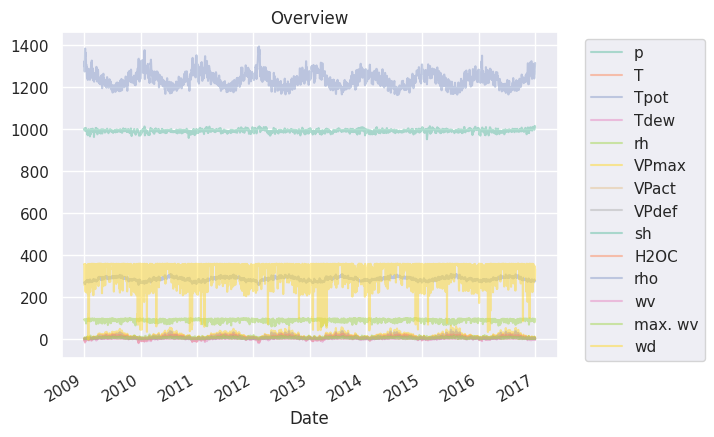

<IPython.core.display.Javascript object>

In [23]:
visualize_time_series_overview(DATA.df)

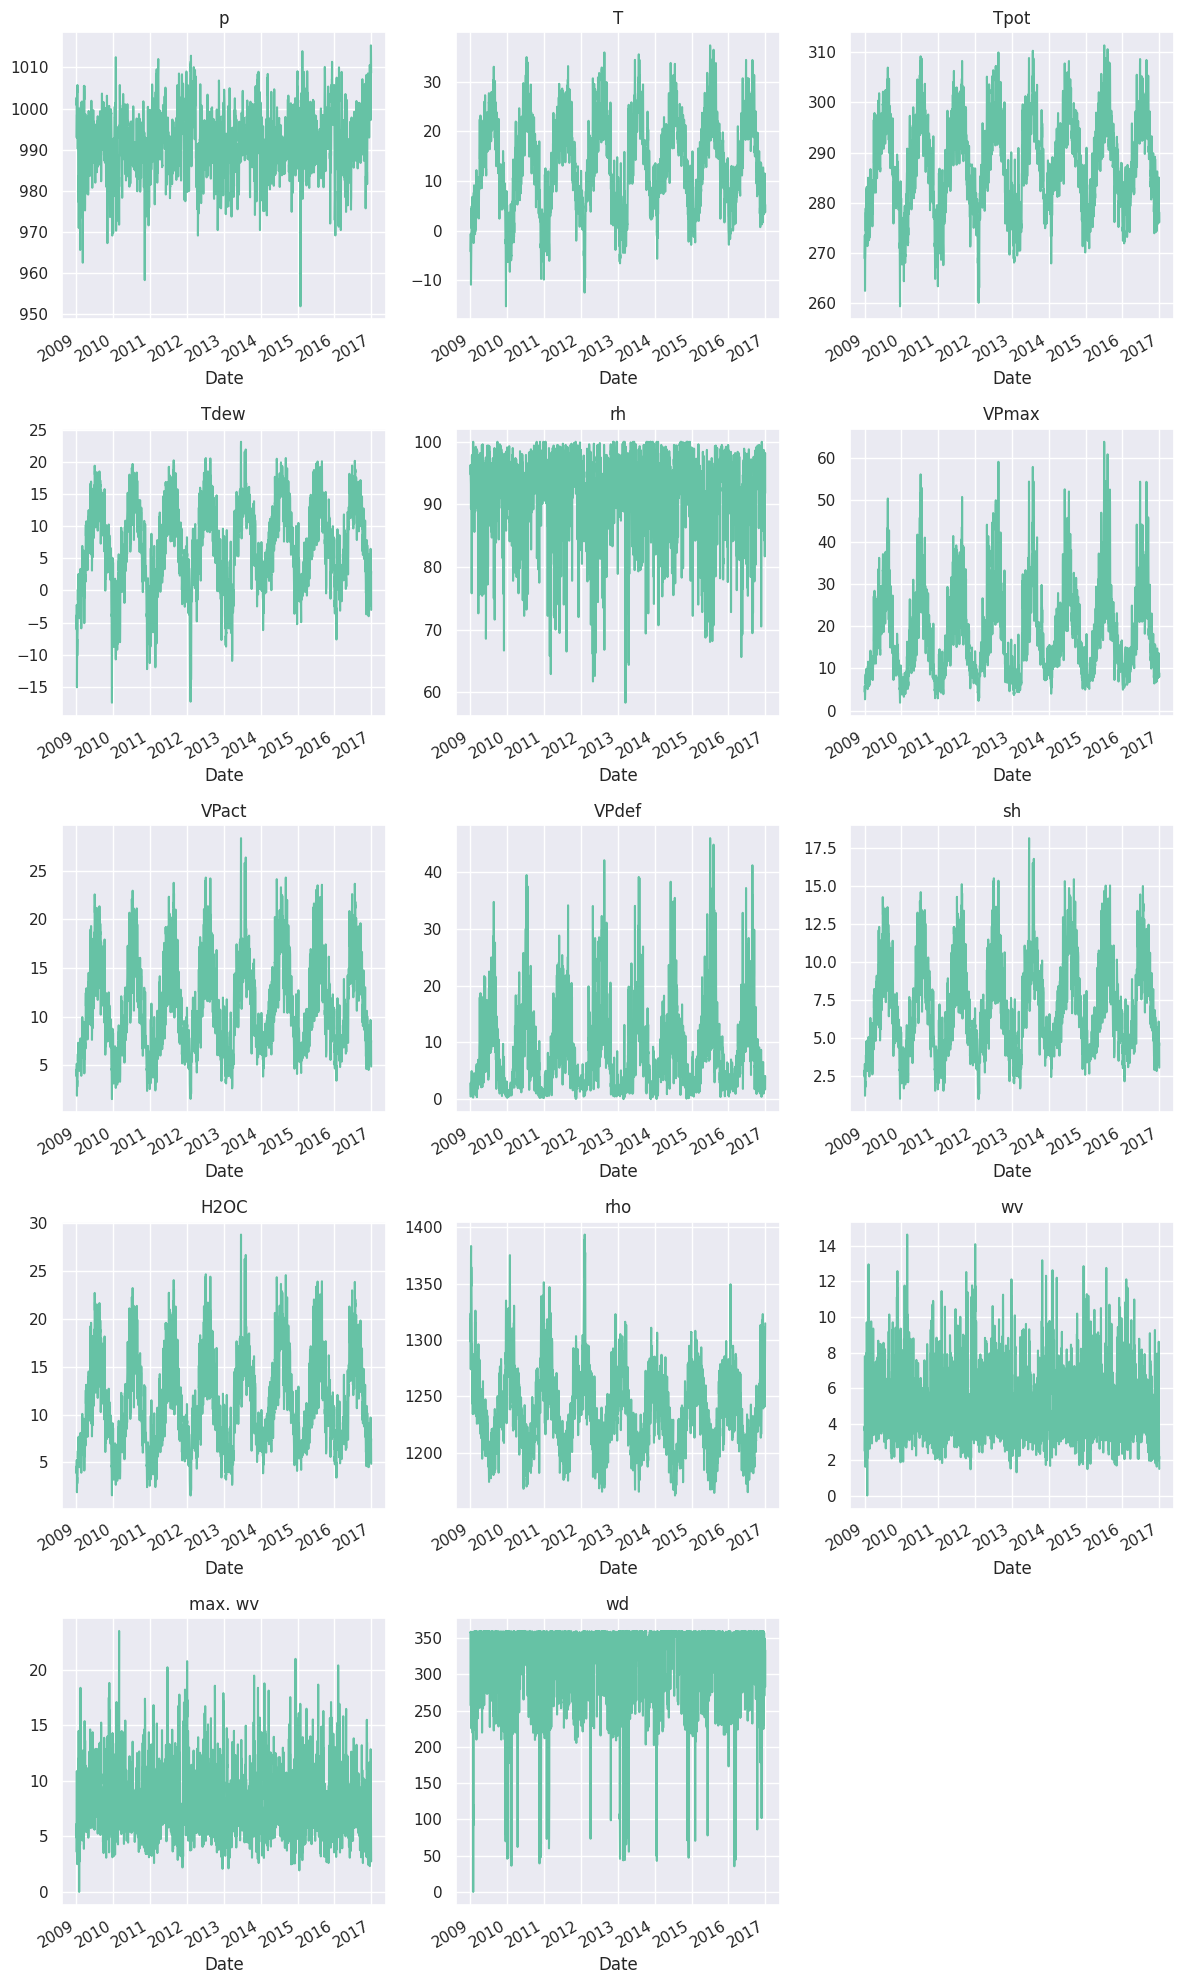

<IPython.core.display.Javascript object>

In [24]:
visualize_time_series_separately(DATA.df)

In [25]:
def plot_fft(y: np.ndarray):
    y_fft = scipy.fft.fft(y)

    N = len(y) // 2
    x_fft_freq = scipy.fft.fftfreq(2 * N)[:N]

    plt.plot(x_fft_freq, np.abs(y_fft[:N]) / N)

<IPython.core.display.Javascript object>

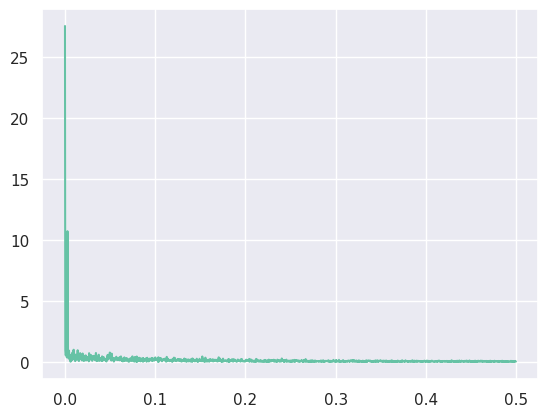

<IPython.core.display.Javascript object>

In [26]:
plot_fft(DATA.target.values)

Имеются ли в данных выбросы? Если да, отфильтруйте данные. Не перестарайтесь, фильтруйте только более менее очевидные выбросы.

Подумайте над тем, какие значения ставить вместо выбросов. Учтите, что не все модели могут обрабатывать пропуски.

---

Я увидел только один очевидный выброс - то, что в один день средняя скорость ветра превысила максимальную:

In [27]:
(DATA.df["wv"] > DATA.df["max. wv"]).sum()

0

<IPython.core.display.Javascript object>

Ограничим скорость ветра максимальной:

In [28]:
DATA.df["wv"] = DATA.df[["wv", "max. wv"]].min(axis="columns")

<IPython.core.display.Javascript object>

#### Задача 4. [1 балл]

Посчитайте матрицу корреляций по всем временным рядам без сдвигов (т.е. $corr(x_t, y_t)$) и визуализируйте ее

<Axes: >

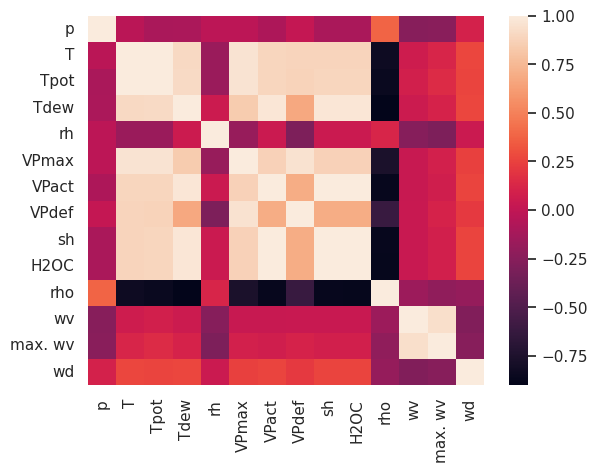

<IPython.core.display.Javascript object>

In [29]:
seaborn.heatmap(DATA.df.corr())

Постройте коррелограмму временного ряда температуры

''

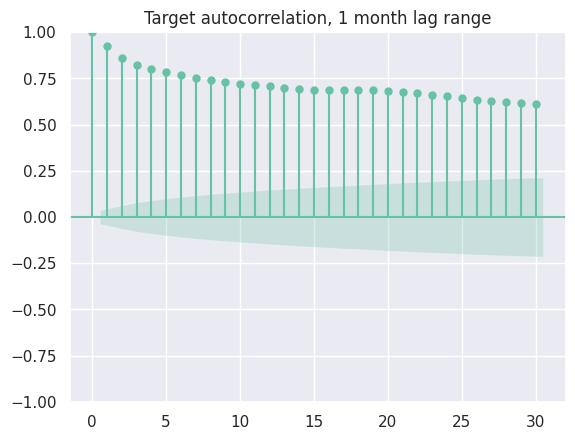

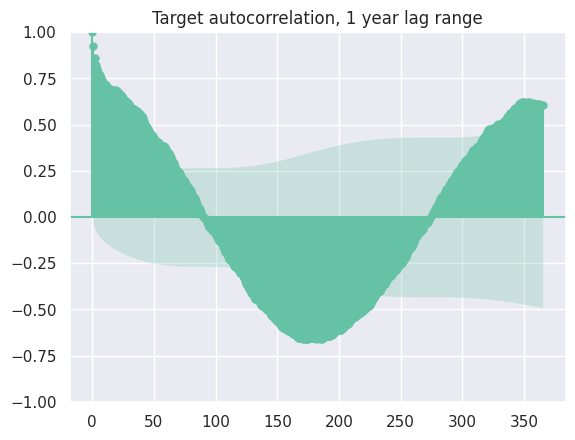

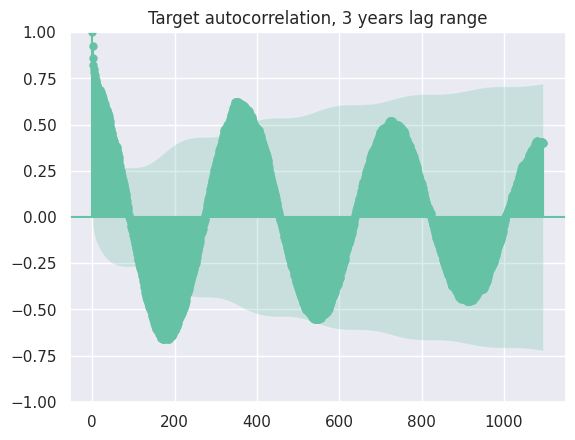

<IPython.core.display.Javascript object>

In [30]:
statsmodels.graphics.tsaplots.plot_acf(
    DATA.target.loc[DATA.train_index],
    lags=30,
    title="Target autocorrelation, 1 month lag range",
)
statsmodels.graphics.tsaplots.plot_acf(
    DATA.target.loc[DATA.train_index],
    lags=365,
    title="Target autocorrelation, 1 year lag range",
)
statsmodels.graphics.tsaplots.plot_acf(
    DATA.target.loc[DATA.train_index],
    lags=365 * 3,
    title="Target autocorrelation, 3 years lag range",
);

По временному ряду температуры выполните STL-разложение и визуализируйте полученные компоненты

''

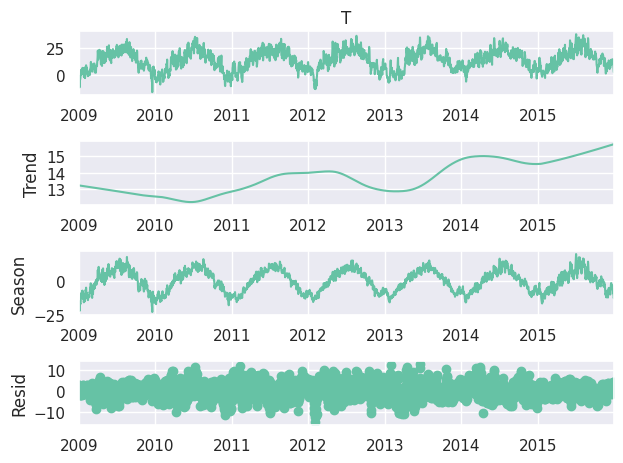

<IPython.core.display.Javascript object>

In [31]:
statsmodels.tsa.seasonal.STL(DATA.target.loc[DATA.train_index], period=365).fit().plot();

**Выводы:**

- Временной ряд температуры значимо автокоррелирован с лагом вплоть до двух месяцев
- Температура также сильно коррелирует с:
    - Tpot, что неудивительно, ведь это просто та же температура в Кельвинах
    - Tdew - температура, скорректированная относительно влажности
    - VPmax, VPact и VPdef, sh, H2OC - показатели, также связанные с влажностью
- Температура имеет выраженную сезонность с периодом в год
- Температура имеет значимый положительный тренд

## 3. Качество<span id=3._Качество_></span>

#### Задача 5. [0.5 балла]

Напишите функции вычисления качества решения в задачи прогнозирования.
Качество решения будем описывать при помощи нескольких метрик качства:
  * mean_squared_error
  * mean_absolute_error
  * mean_absolute_percentage_error
  * median_absolute_error

In [32]:
def mean_squared_error(expected: np.array, predicted: np.array) -> float:
    return ((expected - predicted) ** 2).mean()


def mean_absolute_error(expected: np.array, predicted: np.array) -> float:
    return np.abs(expected - predicted).mean()


def mean_absolute_percentage_error(expected: np.array, predicted: np.array) -> float:
    return (np.abs(expected - predicted) / (np.abs(expected) + 1e-7)).mean() / 100


def median_absolute_error(expected: np.array, predicted: np.array) -> float:
    return np.median(np.abs(expected - predicted))


def compute_metrics(expected: np.array, predicted: np.array) -> dict[str, float]:
    return dict(
        mean_squared_error=mean_squared_error(expected, predicted),
        mean_absolute_error=mean_absolute_error(expected, predicted),
        mean_absolute_percentage_error=mean_absolute_percentage_error(
            expected, predicted
        ),
        median_absolute_error=median_absolute_error(expected, predicted),
    )


def compute_metrics_from_series(predicted: pd.Series) -> dict[str, float]:
    index = predicted.index.intersection(DATA.target.index)
    predicted = predicted.loc[index].values
    expected = DATA.target.loc[index].values
    return compute_metrics(expected, predicted)

<IPython.core.display.Javascript object>

По всем данным посчитайте метрики качества baseline-решения &mdash; прогноз константой (т.е. прогноз последним доступным значением самой прогнозируемой величины), для горизонтов прогнозирования 1, 2, 3.

In [33]:
def get_constant_prediction(
    index: pd.DatetimeIndex, prediction_horizon: int
) -> pd.Series:
    prediction = DATA.df["T"].loc[index]
    prediction = prediction.fillna(method="ffill")
    prediction = prediction.shift(freq=pd.Timedelta(days=prediction_horizon - 1))
    return prediction


def build_constant_prediction_metrics_dataframe(
    prediction_horizon_range, index: pd.DatetimeIndex
) -> pd.DataFrame:
    metrics = []
    for prediction_horizon in prediction_horizon_range:
        prediction = get_constant_prediction(
            index, prediction_horizon=prediction_horizon
        )
        metrics.append(compute_metrics_from_series(prediction))

    df = pd.DataFrame({i: m for i, m in zip(prediction_horizon_range, metrics)})
    df = df.rename_axis(index=f"Metrics", columns="Prediction horizon in days")
    return df

<IPython.core.display.Javascript object>

''

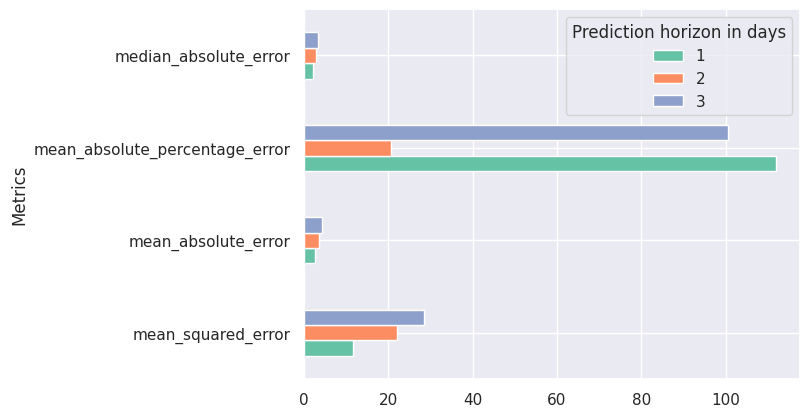

<IPython.core.display.Javascript object>

In [34]:
build_constant_prediction_metrics_dataframe(
    prediction_horizon_range=[1, 2, 3], index=DATA.train_index
).plot(kind="barh");

Посчитайте эти же метрики по скользящим окнам из 4 и 8 недель. Иначе говоря, 
* сначала считаете качество по окну $[t+1, t+\Delta t]$, используя в качестве прогноза $y_t$,
* затем по окну $[t+2, t+\Delta t+1]$, используя в качестве прогноза $y_{t+1}$,
* и так далее.

Постройте графики изменения качества прогноза со временем.

<Axes: ylabel='Metrics'>

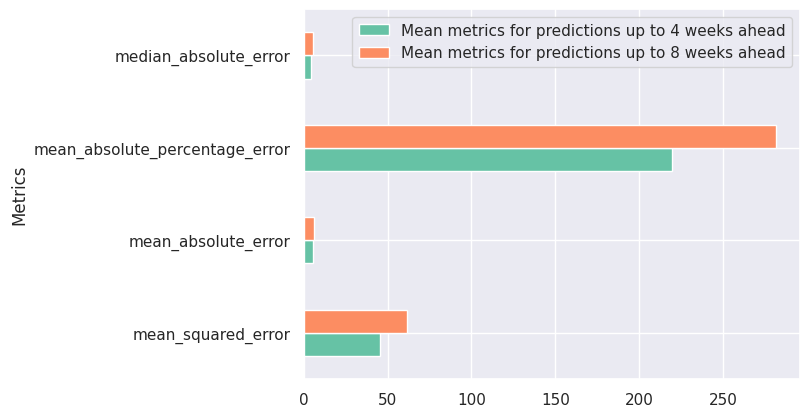

<IPython.core.display.Javascript object>

In [35]:
pd.DataFrame(
    {
        "Mean metrics for predictions up to 4 weeks ahead": build_constant_prediction_metrics_dataframe(
            prediction_horizon_range=range(1, 4 * 7 + 1), index=DATA.train_index
        ).T.mean(),
        "Mean metrics for predictions up to 8 weeks ahead": build_constant_prediction_metrics_dataframe(
            prediction_horizon_range=range(1, 8 * 7 + 1), index=DATA.train_index
        ).T.mean(),
    }
).plot(kind="barh")

''

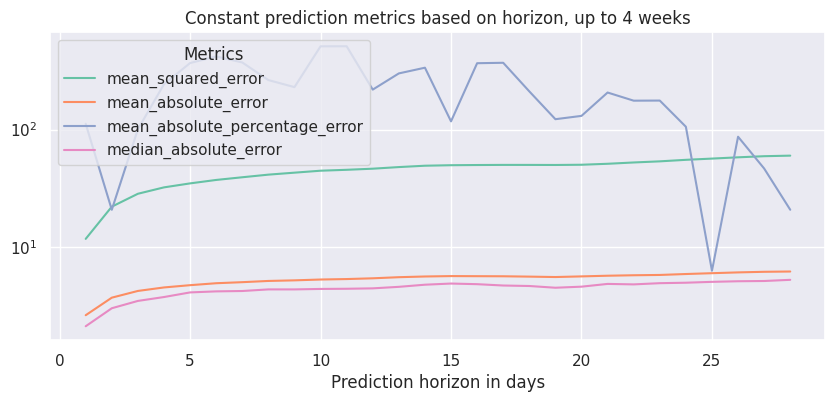

<IPython.core.display.Javascript object>

In [36]:
build_constant_prediction_metrics_dataframe(
    prediction_horizon_range=range(1, 4 * 7 + 1), index=DATA.train_index
).T.plot(
    logy=True,
    figsize=(10, 4),
    title="Constant prediction metrics based on horizon, up to 4 weeks",
);

**Выводы:**

Константное предсказание хорошо работает вплоть до предсказаний на 3 дня вперед, дальше его качество сильно падает.

#### Задача 6. [0.5 балла]

Скользящая валидация с фиксированным размером обучающего периода (*см. в лекциях вариант 1*) реализована в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">sklearn.model_selection.TimeSeriesSplit</a>:

In [37]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv_1 = TimeSeriesSplit(n_splits=5, max_train_size=1000, test_size=8 * 7, gap=70)

for train_index, test_index in ts_cv_1.split(DATA.df):
    ...

<IPython.core.display.Javascript object>

Если вы будете валидировать свои модели по данной схеме, то вы сможете получить наилучшую модель, но не сможете получить несмещённую оценку её качества.
Это важно когда заказчик хочет не только самую лучшую модель по качеству, но и оценку качества этой модели на исторических данных.

Для этого случая имеется альтернативный nested-способ валидации, реализацию которого можно найти по <a href="https://github.com/roelbertens/time-series-nested-cv">ссылке</a>.

Реализуйте nested кросс-валидацию.

In [38]:
def nested_time_series_cross_validation(index, train_size, test_size, n_splits=5):
    if n_splits > 1:
        split_offset = (len(index) - train_size - test_size) // (n_splits - 1)
    else:
        split_offset = 0

    for split_id in range(n_splits):
        train_begin = split_id * split_offset
        train_index = index[train_begin : train_begin + train_size]

        test_begin = train_begin + train_size
        test_index = index[test_begin : test_begin + test_size]

        yield train_index, test_index

<IPython.core.display.Javascript object>

In [39]:
def test_nested_time_series_cross_validation(df):
    train_size = 1000
    test_size = 200

    for (
        train_index,
        test_index,
    ) in nested_time_series_cross_validation(
        df.index, train_size=train_size, test_size=test_size
    ):
        assert len(train_index.intersection(test_index)) == 0
        assert len(train_index) == train_size
        assert len(test_index) == test_size
        assert max(train_index) < min(test_index)

    print("OK")


test_nested_time_series_cross_validation(DATA.df)

OK


<IPython.core.display.Javascript object>

## 4. Сведение к задаче регрессии<span id=4._Сведение_к_задаче_регрессии_></span>

Для получения признакового описания для конкретного момента времени обычно применяют различные оконные функции к таблице данных, что позволяет сэкономить память и вычисления.
Но нужно помнить, что нельзя допустить просачивание информации из будущего, т.к. такие признаки вы не сможете вычислить в продакшне.




#### Задача 7. [0.5 балла]

Вычислите простые признаки вида описательных статистик (сумма, максимум, минимум, стандартное отклонение) по нескольким размерам окон. Признаки можно вычислять не только по температуре, но и по сопутствующим временным рядам.

In [40]:
def compute_contigious_window_stats(df, stat_name: str, window_size, window_offset=0):
    if window_offset != 0:
        df = df.shift(freq=pd.Timedelta(days=window_offset - window_size // 2))

    window = df.rolling(pd.Timedelta(days=window_size))
    stats_df = getattr(window, stat_name)()
    stats_df = stats_df.fillna(method="backfill")

    offset_string = ""
    if window_offset:
        if window_offset % 365 == 0:
            offset_string = f" {window_offset//365} year(s) ago"
        else:
            offset_string = f" {window_offset} day(s) ago"

    stats_df.columns = [
        f"{c} {stat_name} in window of size {window_size}" + offset_string
        for c in stats_df
    ]
    return stats_df

<IPython.core.display.Javascript object>

In [41]:
def build_features_dataframe(
    df,
    column_stat_window_size_window_offset_tuples=(
        ("T", "mean", 1, 0),
        ("T", "mean", 3, 0),
        ("T", "mean", 7, 0),
        ("T", "mean", 7, 365),
        ("T", "mean", 30, 365),
    ),
):
    stats_dfs = []
    for (
        column,
        stat_name,
        window_size,
        window_offset,
    ) in column_stat_window_size_window_offset_tuples:
        stats_dfs.append(
            compute_contigious_window_stats(
                df[[column]],
                stat_name=stat_name,
                window_size=window_size,
                window_offset=window_offset,
            )
        )

    df = pd.concat([df] + stats_dfs, axis="columns")
    return df

<IPython.core.display.Javascript object>

In [42]:
DATA.features = build_features_dataframe(
    DATA.df,
    column_stat_window_size_window_offset_tuples=[
        (c, "mean", 2, 0) for c in DATA.df.columns
    ]
    + [(c, "mean", 7, 365) for c in DATA.df.columns]
    + [(c, "mean", 14, 365 * 2) for c in DATA.df.columns]
    + [(c, "mean", 30, 365 * 3) for c in DATA.df.columns]
    + [
        ("T", "mean", 3, 0),
        ("T", "mean", 4, 0),
        ("T", "mean", 7, 0),
        ("T", "min", 7, 0),
        ("T", "max", 7, 0),
        ("T", "std", 7, 0),
        ("T", "std", 30, 365),
        ("VPmax", "mean", 3, 0),
        ("VPmax", "mean", 7, 0),
        ("VPmax", "std", 7, 0),
        ("VPmax", "std", 30, 365),
    ],
)
DATA.features.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,T mean in window of size 4,T mean in window of size 7,T min in window of size 7,T max in window of size 7,T std in window of size 7,T std in window of size 30 1 year(s) ago,VPmax mean in window of size 3,VPmax mean in window of size 7,VPmax std in window of size 7,VPmax std in window of size 30 1 year(s) ago
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,1000.87,-4.17,269.00,-5.36,94.8,4.48,4.09,0.49,2.55,4.09,...,-4.1700,-4.170,-4.17,-4.17,1.449569,NaN,4.48,4.480,0.523259,NaN
2009-01-02,1002.65,-2.12,271.12,-3.88,96.3,5.22,4.58,0.70,2.86,4.59,...,-3.1450,-3.145,-4.17,-2.12,1.449569,NaN,4.85,4.850,0.523259,NaN
2009-01-03,1002.49,-0.82,272.59,-6.09,93.9,5.75,3.87,2.86,2.41,3.86,...,-2.3700,-2.370,-4.17,-0.82,1.688935,NaN,5.15,5.150,0.637887,NaN
2009-01-04,992.93,-0.63,273.55,-2.26,93.9,5.83,5.17,1.53,3.27,5.25,...,-1.9350,-1.935,-4.17,-0.63,1.630511,NaN,5.60,5.320,0.621986,NaN
2009-01-05,997.54,-1.44,272.89,-2.45,93.2,5.49,5.10,0.83,3.23,5.18,...,-1.2525,-1.836,-4.17,-0.63,1.429311,NaN,5.69,5.354,0.543994,NaN


<IPython.core.display.Javascript object>

#### Задача 8. [0.5 балла]

Обучите градиентый бустинг и обычный многослойный перцептрон с использованием написанного скользящего контроля. Посчитайте качество.

In [43]:
PREDICTIONS = types.SimpleNamespace()
PREDICTIONS.constant = get_constant_prediction(DATA.df.index, prediction_horizon=1)

<IPython.core.display.Javascript object>

In [44]:
def plot_test_metrics():
    predictions = {}
    for model_name, model_predictions in PREDICTIONS.__dict__.items():
        test_predictions = model_predictions.loc[DATA.test_index]
        predictions[model_name] = compute_metrics_from_series(test_predictions)

    pd.DataFrame(predictions).plot(kind="barh", logx=True)

<IPython.core.display.Javascript object>

In [45]:
def fit_catboost_regressor(train_index, val_index=None):
    X_train = DATA.features.loc[train_index]
    y_train = DATA.target.loc[train_index]

    catboost_regressor = catboost.CatBoostRegressor()

    if val_index is None:
        catboost_regressor.fit(X_train, y_train, verbose=False)
        return catboost_regressor

    X_val = DATA.features.loc[val_index]
    y_val = DATA.target.loc[val_index]
    val_pool = catboost.Pool(data=X_val, label=y_val)

    catboost_regressor.fit(X_train, y_train, verbose=False, eval_set=val_pool)

    return catboost_regressor


def compute_catboost_predictions(train_index, test_index, val_index=None):
    catboost_regressor = fit_catboost_regressor(train_index, val_index=val_index)

    X_test = DATA.features.loc[test_index]
    y_pred = catboost_regressor.predict(X_test)

    return pd.Series(index=test_index, data=y_pred)


def compute_catboost_feature_importance(train_index, test_index):
    catboost_regressor = fit_catboost_regressor(train_index)

    X_test = DATA.features.loc[test_index]
    y_test = DATA.target.loc[test_index]
    pool = catboost.Pool(data=X_test, label=y_test)

    return catboost_regressor.get_feature_importance(pool, prettified=True)

<IPython.core.display.Javascript object>

In [46]:
PREDICTIONS.catboost = compute_catboost_predictions(DATA.train_index, DATA.test_index)

<IPython.core.display.Javascript object>

In [47]:
compute_catboost_feature_importance(DATA.train_index, DATA.test_index).style

,Feature Id,Importances
0,T,11.479024
1,VPmax,10.042999
2,Tpot,5.022329
3,VPdef,4.396320
4,T mean in window of size 2,3.300440
5,VPmax mean in window of size 2,3.270510
6,p,2.944799
7,wd,2.643709
8,max. wv,2.578330
9,T mean in window of size 4,2.434822


<IPython.core.display.Javascript object>

In [48]:
def compute_perceptron_predictions(train_index, test_index, val_index=None):
    perceptron = sklearn.neural_network.MLPRegressor(max_iter=500)
    train_features = DATA.features.loc[train_index].fillna(method="bfill").fillna(0)

    perceptron.fit(train_features, DATA.target.loc[train_index])

    test_features = DATA.features.loc[test_index].fillna(method="bfill").fillna(0)
    predictions = perceptron.predict(test_features)
    return pd.Series(index=test_index, data=predictions)

<IPython.core.display.Javascript object>

In [49]:
PREDICTIONS.perceptron = compute_perceptron_predictions(
    DATA.train_index, DATA.test_index
)

<IPython.core.display.Javascript object>

In [50]:
def compute_cross_validation_metrics(
    index: pd.DatetimeIndex,
    compute_predictions: Callable[
        [pd.DatetimeIndex, pd.DatetimeIndex, pd.DatetimeIndex or None], pd.Series
    ],
    train_size=1000,
    test_size=200,
    n_splits=5,
) -> pd.DataFrame:
    metrics = []
    for (
        train_index,
        val_index,
    ) in tqdm.autonotebook.tqdm(
        nested_time_series_cross_validation(
            index, train_size=train_size, test_size=test_size, n_splits=n_splits
        ),
        "Cross validating",
        total=n_splits,
    ):
        predictions = compute_predictions(
            train_index=train_index, test_index=DATA.test_index, val_index=val_index
        )
        metrics.append(compute_metrics_from_series(predictions))

    return pd.DataFrame(metrics)

<IPython.core.display.Javascript object>

In [51]:
compute_cross_validation_metrics(
    index=DATA.train_index, compute_predictions=compute_catboost_predictions
)

Cross validating:   0%|          | 0/5 [00:00<?, ?it/s]

,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,median_absolute_error
0,11.171442,2.706147,0.022065,2.433420
1,10.416044,2.657563,0.025953,2.376978
2,11.249046,2.723192,0.023859,2.391130
3,9.463192,2.512353,0.022178,2.225007
4,9.664565,2.555761,0.020240,2.214852


<IPython.core.display.Javascript object>

In [52]:
compute_cross_validation_metrics(
    index=DATA.train_index, compute_predictions=compute_perceptron_predictions
)

Cross validating:   0%|          | 0/5 [00:00<?, ?it/s]

,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,median_absolute_error
0,13.080167,2.795094,0.011744,2.255399
1,18.903300,3.512362,0.012396,2.990607
2,14.325172,3.002197,0.031637,2.560003
3,15.013355,3.002020,0.013081,2.426817
4,23.933360,3.950049,0.034267,3.412660


<IPython.core.display.Javascript object>

Постройте визуализируйте полученные прогнозы на графике, сравнив их с истинными значениями ряда. Отдельно постройте также график тестового интервала с целью увеличения масштаба графика.

In [53]:
def plot_predictions(index):
    predictions = dict(true=DATA.target.loc[index])
    for model_name, model_predictions in PREDICTIONS.__dict__.items():
        predictions[model_name] = model_predictions.loc[index]

    pd.DataFrame(predictions).plot()

<IPython.core.display.Javascript object>

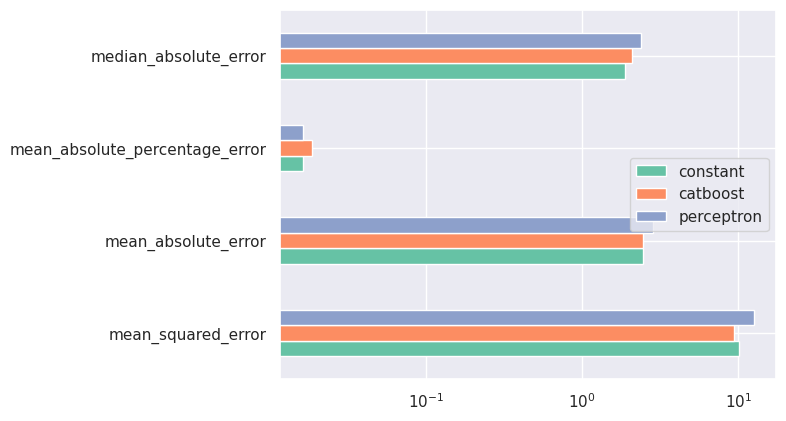

<IPython.core.display.Javascript object>

In [54]:
plot_test_metrics()

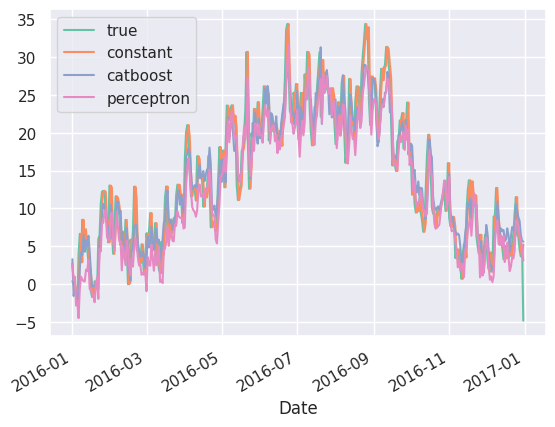

<IPython.core.display.Javascript object>

In [55]:
plot_predictions(DATA.test_index)

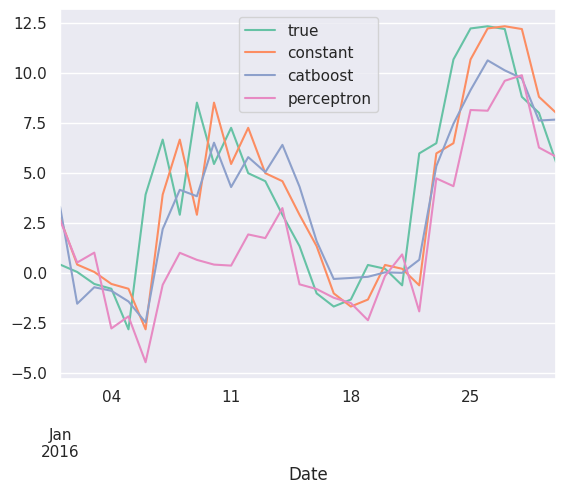

<IPython.core.display.Javascript object>

In [56]:
plot_predictions(DATA.test_index[:30])

#### Задача 9. [1 балл]

Генерировать признаки на этапе знакомства с данными &mdash; не очень интересное занятие.
В отрасли предпринято несколько попыток автоматизировать этот этап.

С помощью библиотеки <a href="https://tsfresh.com/">tsfresh</a> можно довольно быстро сгенерировать большое количество признаков на основе сырых данных временных рядов. Например, по скользящему окну можно вычислить статистики вида минимум, максимум, среднее, количество пиков и т.д.

Ознакомьтесь с данной библиотекой и сгенерируйте признаковое описание. Обратите внимание на функции
* `roll_time_series`
* `extract_features`

In [59]:
def add_entity_id_column_to_df_to_conform_with_tsfresh_format(df):
    df["id"] = 0
    return df


def extract_time_series_features(df, window_size=20):
    df_rolled = tsfresh.utilities.dataframe_functions.roll_time_series(
        add_entity_id_column_to_df_to_conform_with_tsfresh_format(DATA.df),
        column_id="id",
        max_timeshift=window_size,
        min_timeshift=window_size,
    )

    features = tsfresh.extract_features(
        df_rolled,
        column_id="id",
        column_sort="sort",
        impute_function=tsfresh.utilities.dataframe_functions.impute,
    )

    features.index = features.index.droplevel(0)  # drop entity id index

    rank_to_timestamp = pd.Series(index=np.arange(len(df)), data=df.index)
    features.index = rank_to_timestamp[features.index].values

    return features

<IPython.core.display.Javascript object>

In [60]:
tsfresh_features = extract_time_series_features(DATA.df)
DATA.df = DATA.df.drop(["id", "sort"], axis="columns")

Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:35<00:00,  1.68s/it]


<IPython.core.display.Javascript object>

Сколько признаков вы получили? Как побороться с большим числом признаков?

In [61]:
print(f"Number of extracted features: {tsfresh_features.shape[1]}")

Number of extracted features: 10962


<IPython.core.display.Javascript object>

Let's use tsfresh builtin features selection:

In [62]:
def select_feature_columns(features, target, train_index):
    train_features = tsfresh.select_features(
        features.loc[train_index], target.loc[train_index]
    )
    return train_features.columns


def intersect_index_with_features_index(features, index):
    return features.index.intersection(index)

<IPython.core.display.Javascript object>

In [63]:
train_index = intersect_index_with_features_index(tsfresh_features, DATA.train_index)
test_index = intersect_index_with_features_index(tsfresh_features, DATA.test_index)

selected_feature_columns = select_feature_columns(
    tsfresh_features, DATA.target, train_index
)

<IPython.core.display.Javascript object>

In [64]:
print(f"Number of selected features: {len(selected_feature_columns)}")

Number of selected features: 3456


<IPython.core.display.Javascript object>

Обучите модель, посчитайте ее качество и постройте график прогноза.

In [65]:
selected_features = tsfresh_features[selected_feature_columns]

catboost_regressor = catboost.CatBoostRegressor()
catboost_regressor.fit(
    selected_features.loc[train_index], DATA.target.loc[train_index], verbose=False
)

predictions = catboost_regressor.predict(tsfresh_features.loc[test_index])
PREDICTIONS.tsfresh_catboost = pd.Series(index=test_index, data=predictions)

<IPython.core.display.Javascript object>

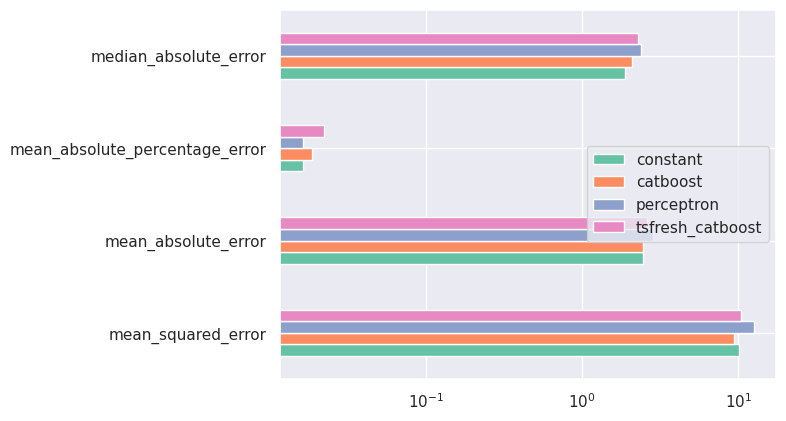

<IPython.core.display.Javascript object>

In [66]:
plot_test_metrics()

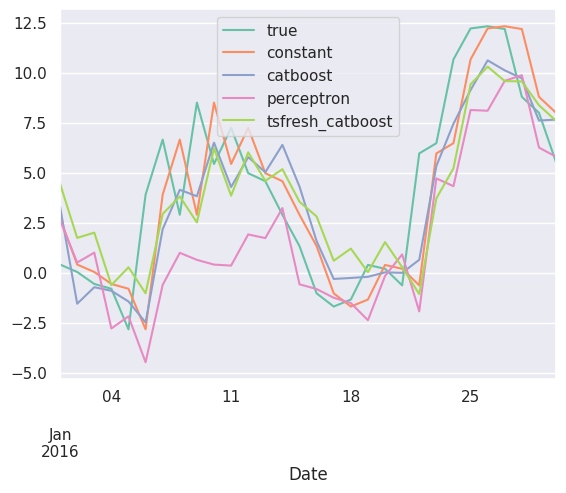

<IPython.core.display.Javascript object>

In [67]:
plot_predictions(DATA.test_index[:30])

**Выводы:**

Из данных метрик ничего не понятно, если честно. Все модели показывают одинаковое качество. Но классно, что теперь я умею пользоваться библиотекой, которая автоматически генерирует признаки по временным рядам. В следующий раз я использую её для построения одного из baseline.

## 5. ARIMA-подобные модели <span id=5._ARIMA-подобные_модели_></span>

#### Задача 10. [1.5 балла]

Обучите модель ARIMA, 
* используя сопутствующие временные ряды в качестве экзогенных факторов,
* используя знания о сезонности,
* подобрав оптимальные гиперпараметры.

*Замечания.*
* Используйте `pmdarima.auto_arima`, которая автоматически подберет гиперпараметры, *см. семинар*.
* Обучение может быть *слишком* вычислительно затратным. Начинайте тестировать код на очень маленьких данных, затем постепенно увеличивайте размер данных.
* Обучение встроенной сезонности может не получиться. В таком случае можно попробовать передать значения за предыдущие сезоны как экзогенные факторы, или же моделировать сезонность рядами Фурье. 

In [68]:
def test_for_non_seasonal_differencing_degree(target: np.ndarray):
    tests = ["kpss", "adf", "pp"]
    for test in tests:
        ndiffs = pmdarima.arima.utils.ndiffs(target, test=test)
        print(f"Per {test} test, differencing degree should be {ndiffs}.")

<IPython.core.display.Javascript object>

In [69]:
test_for_non_seasonal_differencing_degree(DATA.target.values)

Per kpss test, differencing degree should be 0.
Per adf test, differencing degree should be 0.
Per pp test, differencing degree should be 0.


<IPython.core.display.Javascript object>

In [70]:
def test_for_seasonal_differencing_degree(target: np.ndarray, n_seasonal_periods: int):
    tests = ["ocsb"]
    for test in tests:
        nsdiffs = pmdarima.arima.utils.nsdiffs(target, m=n_seasonal_periods, test=test)
        print(f"Per {test} test, seasonal differencing degree should be {nsdiffs}.")

<IPython.core.display.Javascript object>

In [71]:
test_for_seasonal_differencing_degree(DATA.target.values, n_seasonal_periods=365)

Per ocsb test, seasonal differencing degree should be 0.


<IPython.core.display.Javascript object>

Обучите модель, посчитайте ее качество и постройте график прогноза *вместе с предсказательным интервалом*.

In [172]:
class FilterExogenousDataTransformer(pmdarima.preprocessing.base.BaseTransformer):
    def __init__(self, columns: list[str]):
        self.columns = columns

    def fit(self, y, exogenous):
        return self

    def transform(self, y, exogenous):
        return y, exogenous[self.columns]


class IndexTransformer(pmdarima.preprocessing.base.BaseTransformer):
    def fit(self, y, exogenous):
        return self

    def transform(self, y, exogenous):
        exogenous.index = y.index
        return y, exogenous

<IPython.core.display.Javascript object>

In [173]:
n_fourier_features = 3
exogenous_columns = ["VPmax", "wd"]

pipeline = pmdarima.pipeline.Pipeline(
    [
        ("exogenous", FilterExogenousDataTransformer(exogenous_columns)),
        (
            "fourier",
            pmdarima.preprocessing.FourierFeaturizer(m=365, k=n_fourier_features),
        ),
        ("index", IndexTransformer()),
        (
            "arima",
            pmdarima.arima.AutoARIMA(
                seasonal=False,
                trace=True,
                error_action="trace",
                start_p=0,
                max_p=0,
                d=1,
                start_q=5,
                max_q=10,
                information_criterion="bic",
            ),
        ),
    ]
)

pipeline.fit(DATA.target.loc[DATA.train_index], X=DATA.df.loc[DATA.train_index])

Performing stepwise search to minimize aic
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=13265.481, Time=37.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13571.495, Time=1.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13564.670, Time=34.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13569.496, Time=8.88 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=13287.327, Time=35.63 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=13243.803, Time=40.19 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=inf, Time=47.51 sec
 ARIMA(0,1,6)(0,0,0)[0]             : AIC=13242.017, Time=33.39 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=13263.680, Time=33.81 sec
 ARIMA(0,1,7)(0,0,0)[0]             : AIC=13235.270, Time=40.59 sec
 ARIMA(0,1,8)(0,0,0)[0]             : AIC=inf, Time=52.49 sec

Best model:  ARIMA(0,1,7)(0,0,0)[0]          
Total fit time: 366.176 seconds


Pipeline(steps=[('exogenous',
                 FilterExogenousDataTransformer(columns=['VPmax'])),
                ('fourier', FourierFeaturizer(k=10, m=365)),
                ('index', IndexTransformer()),
                ('arima',
                 AutoARIMA(d=1, max_p=0, max_q=10, seasonal=False, start_p=0,
                           start_q=5, trace=True))])

<IPython.core.display.Javascript object>

In [154]:
predictions = []
for timestamp in tqdm.autonotebook.tqdm(DATA.test_index, "Predicting one day ahead"):
    prediction = pipeline.predict(n_periods=1, X=DATA.df.loc[[timestamp]])
    predictions.append(prediction[0])

    pipeline.update(DATA.target.loc[[timestamp]], X=DATA.df.loc[[timestamp]], maxiter=1)

PREDICTIONS.arima = pd.Series(index=DATA.test_index, data=predictions)

Predicting one day ahead:   0%|          | 0/363 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

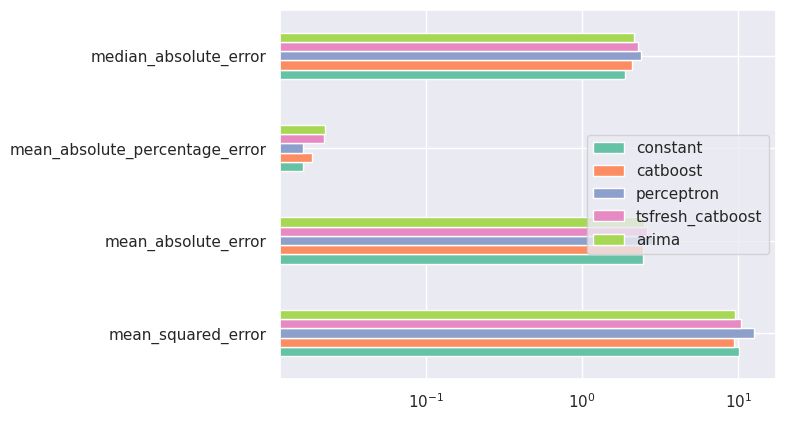

<IPython.core.display.Javascript object>

In [156]:
plot_test_metrics()

Напечатайте саммари модели (`summary()`). Что и как вы можете проинтерпретировать?

In [174]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(0, 1, 7)   Log Likelihood               -6588.635
Date:                Tue, 25 Apr 2023   AIC                          13235.270
Time:                        15:54:52   BIC                          13404.798
Sample:                    01-01-2009   HQIC                         13296.749
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
VPmax             -0.0765      0.028     -2.718      0.007      -0.132      -0.021
FOURIER_S365-0    -2.8219      0.389     -7.262      0.000      -3.584      -2.060
FOURIER_C365-0   -11.2025      0.468    -23.931      0.000     -12.120     -10.285
FOURIER_S365-1     0.2702      0.316      0.856      0.392      -0.349       0.889
FOURIER_C365-1    -0.5643      0.321     -1.756      0.079      -1.194       0.066
FOURIER_S365-2    -0.9256      0.316     -2.930      0.003      -1.545      -0.306
FOURIER_C365-2     0.2113      0.302      0.700      0.484      -0.380       0.803
FOURIER_S365-3     0.3599      0.307      1.173      0.241      -0.242       0.961
FOURIER_C365-3     0.2536      0.298      0.852      0.394      -0.330       0.837
FOURIER_S365-4     0.0375      0.305      0.123      0.902      -0.561       0.636
FOURIER_C365-4     0.4283      0.295      1.454      0.146      -0.149       1.006
FOURIER_S365-5     0.1733      0.293      0.592      0.554      -0.401       0.748
FOURIER_C365-5     0.6481      0.301      2.153      0.031       0.058       1.238
FOURIER_S365-6     0.0868      0.292      0.297      0.766      -0.486       0.660
FOURIER_C365-6     0.5582      0.298      1.872      0.061      -0.026       1.143
FOURIER_S365-7    -0.0034      0.289     -0.012      0.991      -0.570       0.563
FOURIER_C365-7     0.2862      0.297      0.964      0.335      -0.296       0.868
FOURIER_S365-8    -0.4193      0.288     -1.457      0.145      -0.983       0.145
FOURIER_C365-8    -0.1426      0.294     -0.485      0.628      -0.719       0.434
FOURIER_S365-9     0.2372      0.284      0.836      0.403      -0.319       0.793
FOURIER_C365-9    -0.1717      0.287     -0.599      0.549      -0.734       0.390
ma.L1             -0.1047      0.042     -2.470      0.014      -0.188      -0.022
ma.L2             -0.3004      0.021    -14.031      0.000      -0.342      -0.258
ma.L3             -0.2099      0.023     -9.051      0.000      -0.255      -0.164
ma.L4             -0.1288      0.022     -5.939      0.000      -0.171      -0.086
ma.L5             -0.0709      0.020     -3.532      0.000      -0.110      -0.032
ma.L6             -0.0891      0.020     -4.527      0.000      -0.128      -0.051
ma.L7             -0.0601      0.019     -3.222      0.001      -0.097      -0.024
sigma2            10.1619      0.275     36.989      0.000       9.623      10.700
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                16.62
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.12
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients 

<IPython.core.display.Javascript object>

---
Поиск по гиперпараметрам привел к модели ARIMA(0, 1, 7). Что это значит? Сначала разберемся с разницей между AR - авторегрессионной моделью и MA - моделью скользящего среднего. Они задаются следующими формулами:

$\displaystyle{
\text{MA}: x_{t}=\mu +\varepsilon _{t}+\theta _{1}\varepsilon _{t-1}+\cdots +\theta _{q}\varepsilon _{t-q}\\
\text{AR}: x_{t}=\mu +\varepsilon _{t}+\phi _{1}x_{t-1}+\cdots +\phi _{p}x_{t-p}
}$

Нетрудно заметить, что если $\theta_i = \phi_i$ и $p=q$, то модели идентичны. Вообще есть ощущение, что существует изоморфизм между двумя семействами параметрических моделей. Рассмотрим следующий эксперимент: есть натянутая струна, на нее каждую секунду в разных местах капают капли. Нам нужно предсказать состояние струны в каждую секунду. С одной стороны, поскольку струна сама по себе стремится к покою, то ее состояние зависит только от $q$ последних каплей, где $q$ зависит от инертности струны. Если эффект каплей аддитивен, то струну можно моделировать скользящим средним, и состояние струны зависит от $q$ последних внешних шоков. Здесь стоит отметить, что решение считать шок внешним или нет чисто субъективное и зависит от выбора модели. Например, можно сказать, что состояние струны зависит только от её предыдущих состояний и от внешнего шока с момента последнего наблюдения. Это приводит к авторегрессионной модели, опять же в предположении аддитивности состояний. Здесь прошлые шоки уже не считаются внешними, поскольку они включены в прошлые состояния. Вообще нетрудно заметить, что MA можно выразить как AR, и наоборот, но при этом $p$ и $q$ могут уйти в бесконечность. В итоге выбор между MA и AR сводится к тому, какая модель более компактно описывает временной ряд. Если, например, ряд напоминает синус, то с учетом того, что синус в районе нуля хорошо приближается первыми членами разложения Тейлора, то MA будет компактен, а если пытаться представить синус как сумму синусов, то все зависит от периода наблюдений, и AR может оказаться с большим $p$. И наоборот, если зависимость имеет вид $f(x) = \frac{f(x-1) + f(x-2)}{2}$, то AR окажется предпочтительней.

У нас вышла модель ARIMA(0, 1, 7), и можно было бы сказать, что есть значимая линейная связь между внешними шоками и приращениями температуры за последнюю неделю, но на самом деле модель скорее всего также имеет большую авторегрессионную составляющую, но она скрыта в экзогенных переменных, а поскольку они еще к тому же подверглись преобразованию Фурье, их независимая интерпретация практически невозможна.

Далее, тест Ljung-Box гипотезы о независимости остатков дал p-value 0.84, и значит мы не отвергаем эту гипотезу. При этом тест гипотезы о гомоскедастичности остатков дал p-value 0.11, и ее мы тоже не отвергаем. То есть остатки можно считать независимыми и с фиксированной дисперсией, близкими к белому шуму, и можно сказать, что модель сошлась. Но все же тест Jarque-Bera на нормальность остатков подсказывает, что остатки не распределены нормально, и возможно есть значимые неучтенные зависимости.

Также есть соблазн проинтерпретировать значения коэффициентов модели как линейные зависимости между признаками и целевой переменной, но это скорее всего было бы ошибкой - скорее всего признаки зависимы между собой, а даже если и есть линейные зависимости, то это не причинные связи, а корреляции, поскольку температура зависит от многих неучтенных факторов. Из таблицы коэффициентов самый полезный столбец, это, пожалуй, столбец с p-value, который показывает значимость признаков, и руководствуясь которым можно убирать и добавлять признаки.

#### Задача 11. [1 балл]

Обучите модель TBATS, используя знания о сезонности. Выполните те же операции, что и для ARIMA.

In [181]:
y = DATA.target.loc[DATA.train_index].values
tbats_model = tbats.TBATS(seasonal_periods=[365.25])
tbats_model = tbats_model.fit(y)

<IPython.core.display.Javascript object>

In [185]:
print(tbats_model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [365.25]
Seasonal harmonics [1]
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): 0.899372
Trend (Beta): -0.182126
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-3.36668473e-05  6.47980488e-05]
AR coefficients [ 6.47980488e-05 -1.05299888e-01]
MA coefficients [0.08490423]
Seed vector [-2.15027369  1.02804031 -5.18891578 -2.07582323  0.          0.
  0.        ]

AIC 30146.394425


<IPython.core.display.Javascript object>

---
Модель не использовала Box-Cox преобразование, то есть признаки были достаточно нормально распределены. Модель нашла тренд, но удивительно, что он оказался негативным. Тип ARMA оказался (2, 1), а информационный критерий AIC в два раза больше, чем при использовании pmdarima, что неудивительно, ведь pmdarima задает гораздо более сложную модель, у которой больше возможностей подстроиться под данные. 

In [187]:
tbats_predictions = []
for new_observation in tqdm.autonotebook.tqdm(
    DATA.target.loc[DATA.test_index].values, "Predicting one day ahead"
):
    tbats_predictions.append(tbats_model.forecast(steps=1)[0])
    y = np.append(y, new_observation)
    tbats_model = tbats_model.fit(y)

PREDICTIONS.tbats = pd.Series(index=DATA.test_index, data=tbats_predictions)

Predicting one day ahead:   0%|          | 0/363 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

**Выводы:**

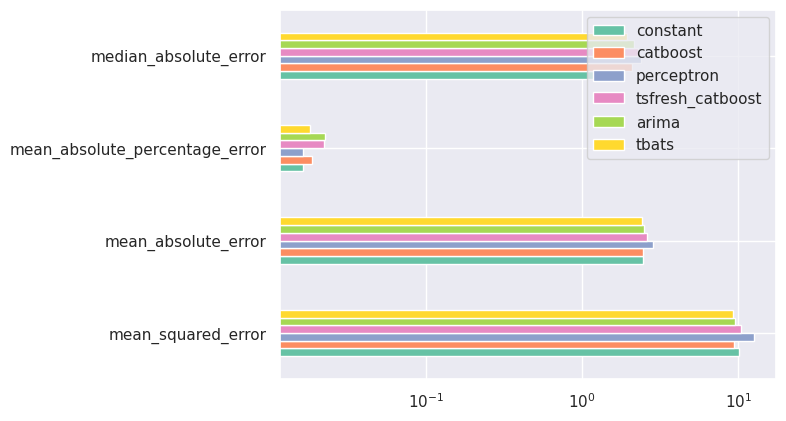

<IPython.core.display.Javascript object>

In [196]:
plot_test_metrics()

tbats и pmdarima во многом похожи, но в силу простоты применения я бы начал с tbats, затем попробовал бы подбирать гиперпараметры в pmdarima, и оценивать, оправданы ли рост сложности и траты ресурсов выигрышем в качестве. 

## 6. Итоговое сравнение <span id=6._Итоговое_сравнение_></span>

#### Задача 12. [0.25 балла]

Составьте итоговую таблицу сравнения качества прогнозов всех рассмотренных моделей по всем метрикам. Постройте график прогнозов для лучших моделей.

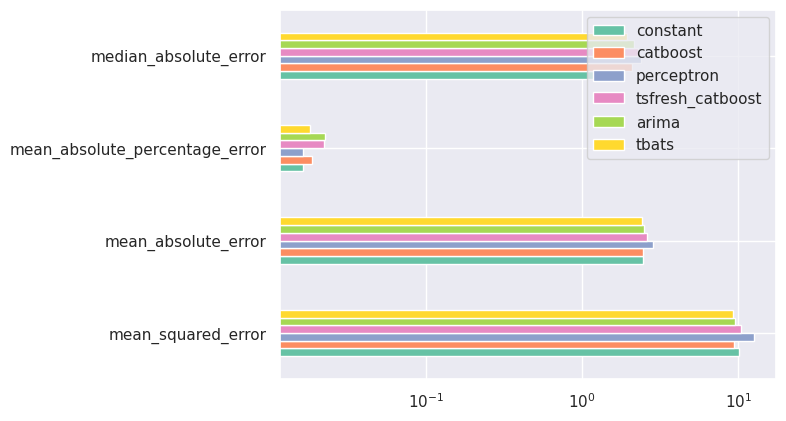

<IPython.core.display.Javascript object>

In [197]:
plot_test_metrics()

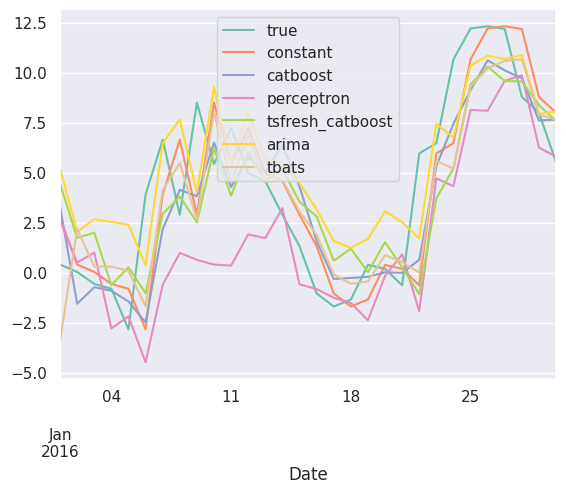

<IPython.core.display.Javascript object>

In [198]:
plot_predictions(DATA.test_index[:30])

**Выводы:**

В данной задаче прогнозирования на 1 день вперед я бы назвал победителем константное предсказание, которое хоть и не показывает лучшие результаты, но компенсирует это с лихвой своей простотой и надежностью. Если же сдвинуть горизонт прогнозирования на неделю вперед, то я бы выбирал между комбо генерации признаков и градиентным бустингом tsfresh+catboost, поскольку эти этапы независимы и стандартны, что дает большую гибкость и возможность пользоваться надежными мощными инструментами, и между pmdarima с предварительной факторизацией признаков на сезонные, трендовые и статичные, поскольку в данной задаче ежегодная сезонность и линейный тренд интуитивно ожидаемы и сильно выражены, что оставляет статичный временной ряд, под который и заточена библиотека pmdarima.